In [ ]:
 import json
import re

import numpy as np 
import pandas as pd
from keras.models import Model
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, add, concatenate
from keras.layers import CuDNNLSTM, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing import text, sequence
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [ ]:
tqdm.pandas()

# Preprocessing <br>To give understandable data to the model and to remove the raw data as it  would cause certain errors.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Loading data

In [ ]:
zomato_orgnl = pd.read_csv('gdrive/MyDrive/zomato.csv', encoding='latin-1')
zomato_orgnl = zomato_orgnl.iloc[:3000,:]
print(zomato_orgnl.shape)
zomato_orgnl.head()

(3000, 17)


,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari


In [ ]:
#Deleting Unnnecessary Columns
zomato=zomato_orgnl.drop(['url','dish_liked','phone'],axis=1) 

In [ ]:
#Removing the Duplicates rows
zomato.duplicated().sum()  #count the duplicate rows
zomato.drop_duplicates(inplace=True)

In [ ]:
zomato.head()

,address,name,online_order,book_table,rate,votes,location,rest_type,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,Banashankari,Casual Dining,"North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,Banashankari,Casual Dining,"Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,Banashankari,"Cafe, Casual Dining","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,Banashankari,Quick Bites,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,Basavanagudi,Casual Dining,"North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari


In [ ]:
#Remove the NaN values from the dataset
zomato.isnull().sum()
zomato.dropna(how='any',inplace=True)
zomato.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2582 entries, 0 to 2999
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   address                      2582 non-null   object
 1   name                         2582 non-null   object
 2   online_order                 2582 non-null   object
 3   book_table                   2582 non-null   object
 4   rate                         2582 non-null   object
 5   votes                        2582 non-null   int64 
 6   location                     2582 non-null   object
 7   rest_type                    2582 non-null   object
 8   cuisines                     2582 non-null   object
 9   approx_cost(for two people)  2582 non-null   object
 10  reviews_list                 2582 non-null   object
 11  menu_item                    2582 non-null   object
 12  listed_in(type)              2582 non-null   object
 13  listed_in(city)              2582

In [ ]:
#Changing the Columns Names
zomato.columns
zomato = zomato.rename(columns={'approx_cost(for two people)':'cost','listed_in(type)':'type',
                                  'listed_in(city)':'city'})
zomato.columns

Index(['address', 'name', 'online_order', 'book_table', 'rate', 'votes',
       'location', 'rest_type', 'cuisines', 'cost', 'reviews_list',
       'menu_item', 'type', 'city'],
      dtype='object')

In [ ]:
zomato.head()

,address,name,online_order,book_table,rate,votes,location,rest_type,cuisines,cost,reviews_list,menu_item,type,city
0,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,Banashankari,Casual Dining,"North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,Banashankari,Casual Dining,"Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,Banashankari,"Cafe, Casual Dining","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,Banashankari,Quick Bites,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,Basavanagudi,Casual Dining,"North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari


In [ ]:
#Some Transformations
zomato['cost'] = zomato['cost'].astype(str) #use to change data type
zomato['cost'] = zomato['cost'].apply(lambda x: x.replace(',','.'))
zomato['cost'] = zomato['cost'].astype(float)
zomato.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2582 entries, 0 to 2999
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   address       2582 non-null   object 
 1   name          2582 non-null   object 
 2   online_order  2582 non-null   object 
 3   book_table    2582 non-null   object 
 4   rate          2582 non-null   object 
 5   votes         2582 non-null   int64  
 6   location      2582 non-null   object 
 7   rest_type     2582 non-null   object 
 8   cuisines      2582 non-null   object 
 9   cost          2582 non-null   float64
 10  reviews_list  2582 non-null   object 
 11  menu_item     2582 non-null   object 
 12  type          2582 non-null   object 
 13  city          2582 non-null   object 
dtypes: float64(1), int64(1), object(12)
memory usage: 302.6+ KB


In [ ]:
#Removing '/5' from Rates
zomato['rate'].unique()
zomato = zomato.loc[zomato.rate !='NEW']
zomato = zomato.loc[zomato.rate !='-'].reset_index(drop=True)
remove_slash = lambda x: x.replace('/5', '') if type(x) == np.str else x
zomato.rate = zomato.rate.apply(remove_slash).str.strip().astype('float')
zomato['rate'].head()

0    4.1
1    4.1
2    3.8
3    3.7
4    3.8
Name: rate, dtype: float64

In [ ]:
df = zomato.copy()

## Retrieve the text data

In [ ]:
all_ratings = []

for ratings in tqdm(df['reviews_list']):
    ratings = eval(ratings)
    
    for score, doc in ratings:
        if score:
            score = score.strip("Rated").strip()  #score/ratings storing
            doc = doc.strip('RATED').strip()   #reviews storing
            
            score = float(score)
            all_ratings.append([score, doc])

100%|██████████| 2410/2410 [00:00<00:00, 4739.51it/s]


In [ ]:
ratings_df = pd.DataFrame(all_ratings, columns=['score', 'doc'])

print(ratings_df.shape)
ratings_df.head()

(54864, 2)


,score,doc
0,4.0,A beautiful place to dine in.The interiors tak...
1,4.0,I was here for dinner with my family on a week...
2,2.0,Its a restaurant near to Banashankari BDA. Me ...
3,4.0,We went here on a weekend and one of us had th...
4,5.0,The best thing about the place is itÃÂÃÂ...


## Remove ratings inside text

Some of the reviews have ratings within it. We want to train a generic model to predict ratings with only text, so we want to hide this extra information so the model does not overfit on that. <br>
Overfitting happens when a model learns the detail and noise in the training data to the extent that it negatively impacts the performance of the model on new data.

"Unhide" the output of the next cell to view sample of the ratings that contain the character `"/"`.

In [ ]:
docs_with_ratings = []
for doc in ratings_df['doc'][:150]:
    if '/' in doc:
        print(doc)
        docs_with_ratings.append(doc)

Great food and pleasant ambience. Expensive but Coll place to chill and relax......

Service is really very very good and friendly staff...

Food : 5/5
Service : 5/5
Ambience :5/5
Overall :5/5
I was looking for a quite place to spend some time with family and as well wanted to try some new place. Since I was at Banashankari I thought of trying this place. The place had good rating and was part of Zomato gold. So I decided to try this place. It was a delite to see a very friendly staff and food we ordered was very tasty as well.

Food : 4/5
Ambience :3/5
Friendly staff : 4/5
Pocket friendly : 4/5

Will definitely visit again ??
Food: 8/10
Ambience:8/10
Staff:8/10
One of the good places to try north Indian food...but depends on ur taste buds. Not everyone will like all the items here. Specially when u r particular abt sweet and spicy food.
There's buffet available too.
We had ordered paneer uttar dakshin and paneer kurchan..was amazing. The Gobi hara pyaz and mix veg were average.
One of

In [ ]:
print(len(docs_with_ratings))

26


We use Regex to find and replace all the occurences of ratings. 
<br>
A RegEx, or Regular Expression, is a sequence of characters that forms a search pattern. RegEx can be used to check if a string contains the specified search pattern.<br>
Let's take a look at all the parts of documents that matches the pattern `[0-9.]*[0-9]/[0-9]*[0-9]`, which correspond to any rating that has double digits (e.g. 10/10), single digits (5/5) or single digits with a fraction (e.g. 9.5/10 or 3.5/5).

In [ ]:
for docs in docs_with_ratings:
    x = re.findall('[0-9.]*[0-9]/[0-9]*[0-9]', docs)
    print(x)

['5/5', '5/5', '5/5', '5/5']
['4/5', '3/5', '4/5', '4/5']
['8/10', '8/10', '8/10']
['6/10', '7/10', '8/10', '7.5/10']
[]
[]
[]
[]
['4/5', '3.5/5', '4/5', '4/5']
['3/5', '3/5', '3/5']
['10/10', '10/10', '10/10', '25/10']
['4/5', '10/5']
['4/5', '4/5', '4/5']
['4/5', '10/5']
['4/5', '4/5', '4/5']
['4/5', '10/5']
['4/5', '4/5', '4/5']
['4/5', '10/5']
['4/5', '4/5', '4/5']
['4/5', '10/5']
['4/5', '4/5', '4/5']
['4/5', '10/5']
['4/5', '4/5', '4/5']
['4.5/5', '4/5', '4.5/5', '4.5/5']
['3.5/5', '4/5', '3.5/5']
['3.5/5', '4/5', '3.5/5']


We will replace them with the word "score", since we do not want the model to overfit on ratings that are already given in the comments.

In [ ]:
doc = docs_with_ratings[0]
subbed_doc = re.sub('[0-9.]*[0-9]/[0-9]*[0-9]', 'score', doc)
print("ORIGINAL:")
print(doc)
print("\nSUBBED:")
print(subbed_doc)

ORIGINAL:
Great food and pleasant ambience. Expensive but Coll place to chill and relax......

Service is really very very good and friendly staff...

Food : 5/5
Service : 5/5
Ambience :5/5
Overall :5/5

SUBBED:
Great food and pleasant ambience. Expensive but Coll place to chill and relax......

Service is really very very good and friendly staff...

Food : score
Service : score
Ambience :score
Overall :score


Now, we do it for all texts.

In [ ]:
ratings_df.head()

,score,doc
0,4.0,A beautiful place to dine in.The interiors tak...
1,4.0,I was here for dinner with my family on a week...
2,2.0,Its a restaurant near to Banashankari BDA. Me ...
3,4.0,We went here on a weekend and one of us had th...
4,5.0,The best thing about the place is itÃÂÃÂ...


## Text Preprocessing

In [ ]:
ratings_df.head()

,score,doc
0,4.0,A beautiful place to dine in.The interiors tak...
1,4.0,I was here for dinner with my family on a week...
2,2.0,Its a restaurant near to Banashankari BDA. Me ...
3,4.0,We went here on a weekend and one of us had th...
4,5.0,The best thing about the place is itÃÂÃÂ...


In [ ]:
## Lower Casing fo the consistency of data and for for string handling
ratings_df['review'] = ratings_df['doc'].str.lower()

In [ ]:
#removing punctuation variable ( !"#$%&'()*+, -./:;<=>?@[\]^_`{|}~ )
import string
PUNCT_TO_REMOVE = string.punctuation  #store punctuation variable 
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

ratings_df['review'] = ratings_df['review'].apply(lambda text: remove_punctuation(text))

In [ ]:
ratings_df=ratings_df.drop(['doc'],axis=1) #axis 0” represents rows and “axis 1” represents columns.

In [ ]:
## Removal of Stopwords
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

ratings_df['review'] = ratings_df['review'].apply(lambda text: remove_stopwords(text))
ratings_df.sample()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,score,review
14765,4.0,simple tasty please visit place love homemadeb...


In [ ]:
## Removal of urls
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

ratings_df['review'] = ratings_df['review'].apply(lambda text: remove_urls(text)) # lambda is looping tech
ratings_df.sample(3)

,score,review
15069,1.0,good
50267,4.0,lassi mud coffee faluda ice cream french fries...
28877,3.0,tandoori good biryani ok compared cost


## One Hot Encoding <br> we convert each categorical value into a new categorical column and assign a binary value of 1 or 0 to those columns to get the better predictions

Let's look at the distribution of ratings

In [ ]:
ratings_df['score'].astype('category').value_counts() #counts the numbers of categorial values

NameError: ignored

Clearly this is categorical data, with some heavy class imbalance.  To want the improve performance. We have encode that into binary labels:

In [ ]:
dummies = pd.get_dummies(ratings_df['score'])
dummies.head()

NameError: ignored

## Train Test Split

Finally, we split the data into train and test sets; the latter will be used to evaluate our model.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    ratings_df['review'], 
    dummies, 
    test_size=0.1, random_state=19
)

Sentiment analysis is a machine learning tool that analyzes texts for polarity, from positive to negative. By training machine learning tools with examples of emotions in text, machines automatically learn how to detect sentiment without human input.

# Building an LSTM Model:- LSTM or long short term memory is a special type of RNN that solves traditional RNN's short term memory problem.

At this point, we are ready to build our model. Similar to the original kernel, we will go through the following steps:
1. Fit the Keras Tokenizer
2. Build an embedding matrix
3. Tokenize and pad our training data
4. Train the model

Once we are done training the model, we evaluate how well it performs. This part is covered in the next section.

## Helper functions to create fasttext embedding

In [ ]:
def build_matrix(word_index, path):
    def get_coefs(word, *arr):
        return word, np.asarray(arr, dtype='float32')

    def load_embeddings(path):
        with open(path) as f:
            embedding_index = {}
            
            for line in tqdm(f):
                word, arr = get_coefs(*line.strip().split(' '))    
                if word in word_index:
                    embedding_index[word] = arr
            
        return embedding_index

    embedding_index = load_embeddings(path)
    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    
    for word, i in tqdm(word_index.items()):
        try:
            embedding_matrix[i] = embedding_index[word]
        except KeyError:
            pass
    return embedding_matrix

In [ ]:
def build_model(embedding_matrix):
    words = Input(shape=(None,))
    x = Embedding(*embedding_matrix.shape, weights=[embedding_matrix], trainable=False)(words)
    x = SpatialDropout1D(0.3)(x)
    x = Bidirectional(CuDNNLSTM(256, return_sequences=True))(x)

    hidden = concatenate([
        GlobalMaxPooling1D()(x),
        GlobalAveragePooling1D()(x),
    ])
    hidden = Dense(256, activation='relu')(hidden)
    hidden1 = Dense(512, activation='relu')(hidden)
    result = Dense(9, activation='softmax')(hidden)
    
    model = Model(inputs=words, outputs=result)
    model.compile(
        loss='categorical_crossentropy', 
        optimizer='Adam',
        metrics=['accuracy']
    )

    return model

## Creating the tokenizer : - What does a Tokenizer do?
The string tokenizer class allows an application to break a string into tokens

In [ ]:
%%time
CHARS_TO_REMOVE = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n“”’\'∞θ÷α•à−β∅³π‘₹´°£€\×™√²—'
tokenizer = text.Tokenizer(filters=CHARS_TO_REMOVE)
tokenizer.fit_on_texts(list(x_train) + list(x_test))

CPU times: user 1.76 s, sys: 12.5 ms, total: 1.77 s
Wall time: 1.77 s


In [ ]:
!unzip "gdrive/MyDrive/crawl-300d-2M.vec.zip" -d "crawl-300d-2M"

Archive:  gdrive/MyDrive/crawl-300d-2M.vec.zip
  inflating: crawl-300d-2M/crawl-300d-2M.vec  


In [ ]:
embedding_matrix = build_matrix(tokenizer.word_index, 'crawl-300d-2M/crawl-300d-2M.vec')

2000001it [02:39, 12543.27it/s]
100%|██████████| 23726/23726 [00:00<00:00, 473581.04it/s]


In [ ]:
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)
x_train = sequence.pad_sequences(x_train, maxlen=384)
x_test = sequence.pad_sequences(x_test, maxlen=384)

## Training

In [ ]:
import tensorflow as tf

In [ ]:
tf.test.is_gpu_available(
    cuda_only=False,
    min_cuda_compute_capability=None
)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [ ]:
model = build_model(embedding_matrix)
model.summary()

checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor='val_accuracy', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

history = model.fit(
    x_train,
    y_train,
    batch_size=512,
    callbacks=[checkpoint],
    epochs=10,
    validation_split=0.1
)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, None, 300)    7118100     ['input_5[0][0]']                
                                                                                                  
 spatial_dropout1d_4 (SpatialDr  (None, None, 300)   0           ['embedding_4[0][0]']            
 opout1D)                                                                                         
                                                                                                  
 bidirectional_4 (Bidirectional  (None, None, 512)   1142784     ['spatial_dropout1d_4[0][0]

In [ ]:
from sklearn.metrics import f1_score

# Evaluation

## Training history

Let's take a look at how well the model is training.

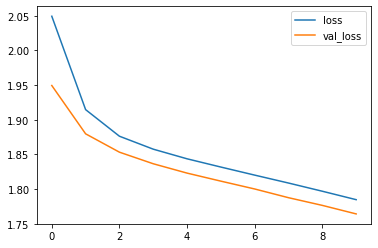

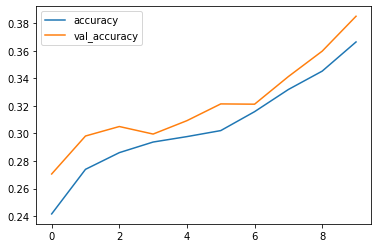

In [ ]:
with open('history.json', 'w') as f:
    json.dump(history.history, f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['accuracy', 'val_accuracy']].plot()

In [ ]:
from sklearn import metrics

In [ ]:
predict_test = model.predict(x_test)
predict_train = model.predict(x_train)

In [ ]:
predict_test

array([[9.3591028e-01, 1.7734187e-03, 5.3389661e-02, ..., 3.5955782e-06,
        2.0639090e-09, 1.6872551e-07],
       [6.6652142e-06, 1.2183227e-07, 2.1786672e-04, ..., 9.5351917e-01,
        2.7216077e-04, 4.1615549e-02],
       [1.7712128e-10, 6.3390584e-11, 1.0290850e-08, ..., 9.9895430e-01,
        2.2033014e-04, 5.5662461e-04],
       ...,
       [8.2536811e-01, 3.5537675e-04, 4.3446343e-02, ..., 1.3285692e-02,
        1.9642964e-07, 4.0670851e-04],
       [7.3420983e-12, 6.8377124e-13, 2.8677094e-08, ..., 9.5665246e-02,
        1.1860322e-04, 9.0414643e-01],
       [9.3839371e-01, 4.3461198e-04, 1.2415619e-02, ..., 2.5320776e-02,
        7.2726702e-06, 1.2692118e-03]], dtype=float32)

In [ ]:
predict_train

array([[9.9941671e-01, 5.2009657e-04, 6.3145162e-05, ..., 3.4849474e-12,
        8.9319399e-13, 7.6085194e-11],
       [1.9913364e-11, 8.9118903e-12, 1.8621588e-10, ..., 7.0700960e-05,
        1.5455048e-04, 9.9977428e-01],
       [4.7018964e-02, 4.1633341e-04, 9.3362248e-01, ..., 3.7018755e-05,
        9.8256061e-09, 9.1478723e-06],
       ...,
       [3.2635930e-04, 7.2690259e-06, 3.0706811e-04, ..., 1.3007452e-04,
        3.9468443e-07, 8.8996123e-05],
       [3.5081071e-01, 4.6861870e-04, 5.1644480e-01, ..., 7.8937868e-03,
        1.3453283e-06, 6.2149564e-05],
       [3.2293997e-07, 5.3376493e-07, 2.4087643e-03, ..., 3.2171531e-05,
        1.7620810e-07, 1.6931586e-05]], dtype=float32)

In [ ]:
print("Test R2: {0:.4f}".format(metrics.r2_score(y_test, predict_test)))    #give corelation variation 
print("Train R2: {0:.4f}".format(metrics.r2_score(y_train, predict_train)))
print()
print("Test MSE: {0:.4f}".format(metrics.mean_squared_error(y_test, predict_test)))
print("Train MSE: {0:.4f}".format(metrics.mean_squared_error(y_train, predict_train)))  #MSE is used to check how close estimates are to actual values. Lower the MSE, the closer is forecast to actual.
print()
print("Test RMSE: {0:.4f}".format(metrics.mean_squared_error(y_test, predict_test) ** 0.5))
print("Train RMSE: {0:.4f}".format(metrics.mean_squared_error(y_train, predict_train) ** 0.5)) #measure of the differences between values predicted by a model or an estimator and the values observed
print()


Test R2: 0.7668
Train R2: 0.8748

Test MSE: 0.0217
Train MSE: 0.0129

Test RMSE: 0.1475
Train RMSE: 0.1136



## End of the notebook